# DenseNet On Nature Dataset

In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [ ]:
import opendatasets as od
import PIL
import glob
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def mount_drive(fr = False):
    from google.colab import drive
    drive.mount("/content/drive/", force_remount = fr)

# Loading Dataset

In [ ]:
def fetch_nature():
    
    mount_drive(False)
    
    # Choose your image size
    # AlexNet
    IMAGE_SIZE = (227, 227)
    
    output = []

    class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
    index  = [0, 1, 2, 3, 4, 5]

    # Build a dictionary that maps the category to an index/integer

    class_names_label = dict(list((zip(class_names, index))))

    # Iterate through training and test sets
    def function1(dataset):
      
        images = []
        labels = []

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # This function specifically is what resizes, IMAGE_SIZE is defined above
                image = cv2.resize(image, IMAGE_SIZE) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        # Shuffling
        images, labels = sklearn.utils.shuffle(images, labels)

        # Normalizing data
        images = images / 255.0
        
        #One-hot encoding
        labels = pd.get_dummies(pd.Series(labels)).to_numpy()

        return images, labels

    (image_train, label_train), (image_test, label_test) =  function1('/content/drive/MyDrive/Colab Notebooks/DATA4380-project/Natural_Imagery_Dataset/seg_train/seg_train'), function1('/content/drive/MyDrive/Colab Notebooks/DATA4380-project/Natural_Imagery_Dataset/seg_test/seg_test')

    return image_train, label_train, image_test, label_test

In [ ]:
image_train, label_train, image_test, label_test = fetch_nature() 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# DenseNet Model Set up

In [ ]:
def dense121(IMAGE_SIZE):
    # Define input layer
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    
    # Preprocessing layers
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # DenseBlock 1
    x = dense_block(x, 6, 32)
    # Transition Layer 1
    x = transition_layer(x, 128)
    
    # DenseBlock 2
    x = dense_block(x, 6, 32) # increase growth rate
    # Transition Layer 2
    x = transition_layer(x, 228)
    
    # DenseBlock 3
    x = dense_block(x, 12, 128) # increase growth rate
    # Transition Layer 3
    x = transition_layer(x, 478)
    
    # DenseBlock 4
    x = dense_block(x, 16, 128) # increase growth rate
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Output layer
    outputs = Dense(6, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs, outputs, name='densenet121')
    
    return model
def conv_block(x, growth_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, 3, padding='same')(x)
    return x

def dense_block(x, layers, growth_rate):
    for i in range(layers):
        conv = conv_block(x, growth_rate)
        x = concatenate([x, conv])
    return x

def transition_layer(x, filters):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 1)(x)
    x = AveragePooling2D(2, strides=2)(x)
    return x

In [ ]:
print(image_train.shape)
print(label_train.shape)
print(image_test.shape)
print(label_test.shape)

(14034, 227, 227, 3)
(14034, 6)
(3000, 227, 227, 3)
(3000, 6)


In [ ]:
image_train_redc = image_train[:4666]
print(image_train_redc.shape)
label_train_redc = label_train[:4666]
print(label_train_redc.shape)

(4666, 227, 227, 3)
(4666, 6)


# Training

In [ ]:
model_2 = dense121(IMAGE_SIZE=(227, 227, 3))
model_2.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 114, 114, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 114, 114, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                       

In [ ]:
model_2.compile(optimizer= Adam(lr= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_2.fit(x=image_train_redc, y=label_train_redc,validation_data=(image_test, label_test),
                      validation_steps=3,
                      shuffle=2, 
                      verbose=1, 
                      epochs=30, 
                      batch_size=64)

Epoch 1/30
73/73 [==============================] - 67s 250ms/step - loss: 6.4837 - accuracy: 0.3536 - val_loss: 109.5444 - val_accuracy: 0.1823
Epoch 2/30
73/73 [==============================] - 8s 106ms/step - loss: 2.6328 - accuracy: 0.3821 - val_loss: 622.5540 - val_accuracy: 0.1771
Epoch 3/30
73/73 [==============================] - 8s 106ms/step - loss: 1.9725 - accuracy: 0.4333 - val_loss: 3.5550 - val_accuracy: 0.2083
Epoch 4/30
73/73 [==============================] - 8s 106ms/step - loss: 2.0318 - accuracy: 0.4835 - val_loss: 1.5469 - val_accuracy: 0.4062
Epoch 5/30
73/73 [==============================] - 8s 107ms/step - loss: 1.5036 - accuracy: 0.5493 - val_loss: 3.0927 - val_accuracy: 0.2500
Epoch 6/30
73/73 [==============================] - 8s 106ms/step - loss: 1.2697 - accuracy: 0.5463 - val_loss: 1.7487 - val_accuracy: 0.2969
Epoch 7/30
73/73 [==============================] - 8s 106ms/step - loss: 1.1693 - accuracy: 0.5977 - val_loss: 1.2444 - val_accuracy: 0.4531
E

# Rough Table

In [ ]:
# Assuming your test data is stored in numpy arrays called `imagetest` and `labeltest`
batch_size = 64
test_ds = tf.data.Dataset.from_tensor_slices((image_test, label_test)).batch(batch_size)

# Generate predictions for the test dataset
test_predictions = model_2.predict(test_ds)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Compute classification report and print results
report = classification_report(label_test.argmax(axis=1), test_predictions_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(tabulate(df_report, headers='keys', tablefmt='psql'))

47/47 [==============================] - 6s 82ms/step
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0            |    0.584022 | 0.807619 |   0.677858 |  525        |
| 1            |    0.803883 | 0.826347 |   0.814961 |  501        |
| 2            |    0.831746 | 0.473779 |   0.603687 |  553        |
| 3            |    0.809019 | 0.697941 |   0.749386 |  437        |
| 4            |    0.705882 | 0.847059 |   0.770053 |  510        |
| 5            |    0.918681 | 0.881857 |   0.899892 |  474        |
| accuracy     |    0.751667 | 0.751667 |   0.751667 |    0.751667 |
| macro avg    |    0.775539 | 0.755767 |   0.752639 | 3000        |
| weighted avg |    0.77277  | 0.751667 |   0.748256 | 3000        |
+--------------+-------------+----------+------------+-------------+


# Training Curves

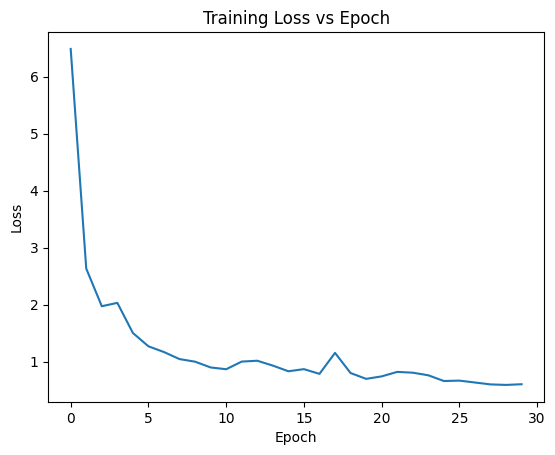

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Evaluations

In [ ]:
scores = model_2.evaluate(image_test, label_test)
print(scores)

94/94 [==============================] - 5s 36ms/step - loss: 0.6523 - accuracy: 0.7517
[0.6523266434669495, 0.7516666650772095]


In [ ]:
y_pred = model_2.predict(image_test)

94/94 [==============================] - 3s 20ms/step


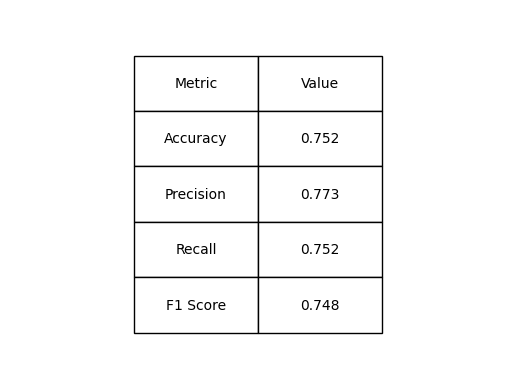

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
label_test_classes = np.argmax(label_test, axis=1)

accuracy = scores[1]
type(accuracy)

precision = precision_score(label_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(label_test_classes, y_pred_classes, average='weighted')
recall = recall_score(label_test_classes, y_pred_classes, average='weighted')

headers = ["Metric", "Value"]
data = [
    
    ["Accuracy", "%.3f" % accuracy],
    ["Precision", "%.3f" % precision],
    ["Recall", "%.3f" % recall],
    ["F1 Score", "%.3f" % f1],
]

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=data, colLabels=headers, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()